In [307]:
import os
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from itertools import combinations
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random
from sklearn.neighbors.kde import KernelDensity


In [351]:
dataset_name = 'ihart.ms2'
ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped']
assembly = '38'

#dataset_name = 'all_wgs'
#ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped',
#             '../../DATA/ssc.hg38/ssc.ped'
#            ]
#assembly = '38'

#dataset_name = 'spark'
#ped_files = ['../../DATA/spark/sparkfam.ped']
#assembly = '38'

#phase_dir = '../phased_ancestry_quads_del'
#ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#assembly = '38'

In [352]:
child_to_mom = dict()
child_to_dad = dict()

sample_to_sex = dict()
sample_to_affected = dict()
parents_to_children = defaultdict(list)

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            sample_to_sex[pieces[1]] = pieces[4]
            sample_to_affected[pieces[1]] = pieces[5]
            if pieces[2] != '0' and pieces[3] != '0':
                parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
                child_to_mom[pieces[1]] = pieces[3]
                child_to_dad[pieces[1]] = pieces[2]                

In [353]:
sibpairs = []
mom_recomb, dad_recomb = [], []

with open('../%s/sibpairs.json' % dataset_name, 'r') as f:
    for (phase_file, family, child1, child2), mat_ibd, pat_ibd, mat_crossovers, pat_crossovers, \
    mat_gcs, mat_gcs in json.load(f):
        if mat_ibd != -1 and pat_ibd != -1:
            sibpairs.append((child1, child2))
            #mom_recomb.append(mat_crossovers)
            #dad_recomb.append(pat_crossovers)
            mom_recomb.append(mat_gcs)
            dad_recomb.append(mat_gcs)

mom_recomb = np.array(mom_recomb)
dad_recomb = np.array(dad_recomb)

children = sorted(set(sum([[x[0], x[1]] for x in sibpairs], [])))
child_to_index = dict([(x, i) for i, x in enumerate(children)])

print(len(sibpairs), len(mom_recomb), len(dad_recomb))
print(len(children))

1968 1968 1968
2178


In [354]:
sibpair_to_child = np.zeros((len(sibpairs), len(children)), dtype=int)
for i, (sib1, sib2) in enumerate(sibpairs):
    sibpair_to_child[i, child_to_index[sib1]] = 1
    sibpair_to_child[i, child_to_index[sib2]] = 1

# Check maternal/paternal age at birth

In [355]:
# pull parental ages
#child_to_mom_age_at_birth = dict()
#child_to_dad_age_at_birth = dict()
#with open('../phenotypes/mssng/agre_affchild1.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    mat_age_index = header.index('MATERNAL_AGE_AT_PARTURITION')
#    pat_age_index = header.index('PATERNAL_AGE_AT_PARTURITION')
#    for pieces in reader:
#        if float(pieces[mat_age_index]) > 10:
#            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
#        if float(pieces[pat_age_index]) > 10:
#            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
#print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


In [356]:
person_to_age = dict()
with open('../phenotypes/spark/individuals.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('age_at_registration_months')
    for pieces in reader:
        person_to_age[pieces[0]] = int(pieces[age_index])/12

In [357]:
#with open('../phenotypes/mssng/rmq.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    mat_age_index = header.index('MOMAGE')
#    pat_age_index = header.index('DADAGE')
#    for pieces in reader:
#        try:
#            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
#        except ValueError:
#            pass
#        try:
#            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
#        except ValueError:
#            pass
#print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


In [358]:
person_to_birthyear = dict()
filenames = ['../phenotypes/ihart/Medical History Mother/MotherH1.csv',
             '../phenotypes/ihart/Medical History Father/FatherH1.csv',
             '../phenotypes/ihart/Medical History Affected Child/AffChild1.csv',
             '../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv',
             '../phenotypes/ihart/Language Questionnaire/Language_Questionnaire1.csv',
             '../phenotypes/ihart/Handedness/Hands1.csv',
             '../phenotypes/ihart/AGRE_PhysMeas1.csv',
             '../phenotypes/ihart/AGRE Physical Measurements/AGRE_PhysMeas1.csv',
            ]

for filename in filenames:
    print(filename)
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('age')
        sample_id_index = header.index('Individual ID')
        date_index = header.index('data_entry_date')
        for pieces in reader:
            try:
                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass
            
#with open('../phenotypes/mssng/bodymeas.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    age_index = header.index('AgeN')
#    sample_id_index = header.index('Id')
#    date_index = header.index('testdate')
#    for pieces in reader:
#        try:
#            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
#            person_to_birthyear[pieces[sample_id_index]] = birth_year
#        except ValueError:
#            pass
#        
#with open('../phenotypes/mssng/srsadultresearchform.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    age_index = header.index('SRSAAGE')
#    sample_id_index = header.index('Id')
#    date_index = header.index('testdate')
#    for pieces in reader:
#        try:
#            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
#            person_to_birthyear[pieces[sample_id_index]] = birth_year
#        except ValueError:
#            pass
#        
#with open('../phenotypes/mssng/srsparentreportforchild.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    age_index = header.index('SRSAGE')
#    sample_id_index = header.index('Id')
#    date_index = header.index('testdate')
#    for pieces in reader:
#        try:
#            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
#            person_to_birthyear[pieces[sample_id_index]] = birth_year
#        except ValueError:
#            pass
#
#filenames = ['../phenotypes/mssng/agre_srs2srs20021.csv',
#             '../phenotypes/mssng/agre_srs2006preschool1.csv',
#             '../phenotypes/mssng/agre_srs20061.csv',
#            ]
#for filename in filenames:
#    with open(filename, 'r') as f:
#        reader = csv.reader(f)
#        header = next(reader)
#        age_index = header.index('AGE')
#        sample_id_index = header.index('Id')
#        date_index = header.index('testdate')
#        for pieces in reader:
#            try:
#                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
#                person_to_birthyear[pieces[sample_id_index]] = birth_year
#            except ValueError:
#                pass#
#
#        
filenames = ['../phenotypes/ihart/SRS/SRS_2006_Preschool1.csv',
            '../phenotypes/ihart/SRS/SRS_20061_Adult.csv',
            '../phenotypes/ihart/SRS/SRS_20061_Child.csv',
            '../phenotypes/ihart/SRS/SRS_20061.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021_Child.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021_Preschool.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021.csv'
            ]
for filename in filenames:
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('age')
        sample_id_index = header.index('Individual ID')
        year_index = header.index('InterviewYear')
        month_index = header.index('InterviewMonth')
        day_index = header.index('InterviewDay')
        for pieces in reader:
            try:
                birth_year = (datetime.date(int(pieces[year_index]), int(pieces[month_index]), int(pieces[day_index])) - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass
print(len(person_to_birthyear))


../phenotypes/ihart/Medical History Mother/MotherH1.csv
../phenotypes/ihart/Medical History Father/FatherH1.csv
../phenotypes/ihart/Medical History Affected Child/AffChild1.csv
../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv
../phenotypes/ihart/Language Questionnaire/Language_Questionnaire1.csv
../phenotypes/ihart/Handedness/Hands1.csv
../phenotypes/ihart/AGRE_PhysMeas1.csv
../phenotypes/ihart/AGRE Physical Measurements/AGRE_PhysMeas1.csv
8326


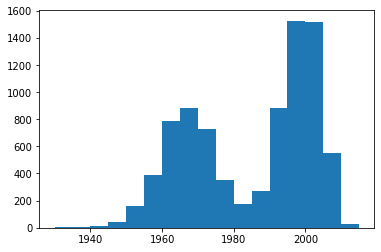

In [359]:
plt.hist(person_to_birthyear.values(), bins=np.arange(1930, 2020, 5))
plt.show()

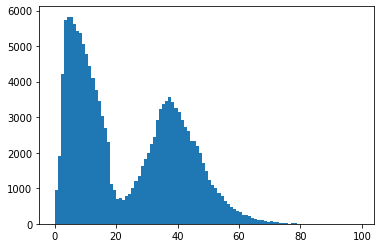

In [360]:
plt.hist(person_to_age.values(), bins=np.arange(0, 100))
plt.show()

In [361]:
mom_age_at_birth = -np.ones((len(children),), dtype=int)
dad_age_at_birth = -np.ones((len(children),), dtype=int)

for i, child in enumerate(children):
    if child in child_to_mom:
        mom = child_to_mom[child]
        age_at_birth = None
        if child in person_to_age and mom in person_to_age:
            age_at_birth = person_to_age[mom]-person_to_age[child]
        elif child in person_to_birthyear and mom in person_to_birthyear:
            age_at_birth = person_to_birthyear[child]-person_to_birthyear[mom]
            
        if age_at_birth is not None and age_at_birth > 10 and age_at_birth < 60:
            mom_age_at_birth[i] = age_at_birth
            
    if child in child_to_dad:
        dad = child_to_dad[child]
        age_at_birth = None
        if child in person_to_age and dad in person_to_age:
            age_at_birth = person_to_age[dad]-person_to_age[child]
        elif child in person_to_birthyear and dad in person_to_birthyear:
            age_at_birth = person_to_birthyear[child]-person_to_birthyear[dad]
            
        if age_at_birth is not None and age_at_birth > 10 and age_at_birth < 60:
            dad_age_at_birth[i] = age_at_birth

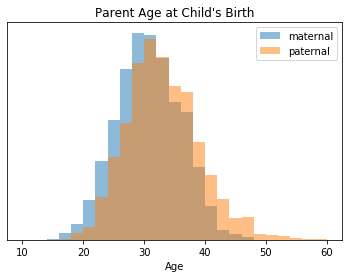

In [362]:

plt.hist(mom_age_at_birth,
        alpha=0.5, bins=np.arange(10, 62, 2), label='maternal')
plt.hist(dad_age_at_birth,
        alpha=0.5, bins=np.arange(10, 62, 2), label='paternal')
plt.title("Parent Age at Child's Birth")
plt.legend()
plt.xlabel('Age')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.show()


# Now look at relationship between parental age and recombinations

In [363]:
# sibpairs where both children have age
both_have_mom_age = np.array([int(mom_age_at_birth[child_to_index[sib1]]!=-1 and mom_age_at_birth[child_to_index[sib2]]!=-1) for sib1, sib2 in sibpairs])
both_have_dad_age = np.array([int(dad_age_at_birth[child_to_index[sib1]]!=-1 and dad_age_at_birth[child_to_index[sib2]]!=-1) for sib1, sib2 in sibpairs])

print(np.sum(both_have_mom_age), np.sum(both_have_dad_age))


1557 1527


## linear age model


In [364]:

X_mat = np.zeros((len(children), 3))
X_mat[mom_age_at_birth != -1, 0] = mom_age_at_birth[mom_age_at_birth != -1]
X_mat[mom_age_at_birth != -1, 1] = 1
X_mat[:, 2] = 1

mat_model_linear = sm.GLM(mom_recomb, sibpair_to_child.dot(X_mat))
mat_results_linear = mat_model_linear.fit()
print(mat_results_linear.summary())
print(mat_results_linear.pvalues)

X_pat = np.zeros((len(children), 3))
X_pat[dad_age_at_birth != -1, 0] = dad_age_at_birth[dad_age_at_birth != -1]
X_pat[dad_age_at_birth != -1, 1] = 1
X_pat[:, 2] = 1

pat_model_linear = sm.GLM(dad_recomb, sibpair_to_child.dot(X_pat))
pat_results_linear = pat_model_linear.fit()
print(pat_results_linear.summary())
print(pat_results_linear.pvalues)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1968
Model:                            GLM   Df Residuals:                     1965
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          50.450
Method:                          IRLS   Log-Likelihood:                -6649.2
Date:                Thu, 14 Oct 2021   Deviance:                       99134.
Time:                        18:15:05   Pearson chi2:                 9.91e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0247      0.018     -1.360      0.1

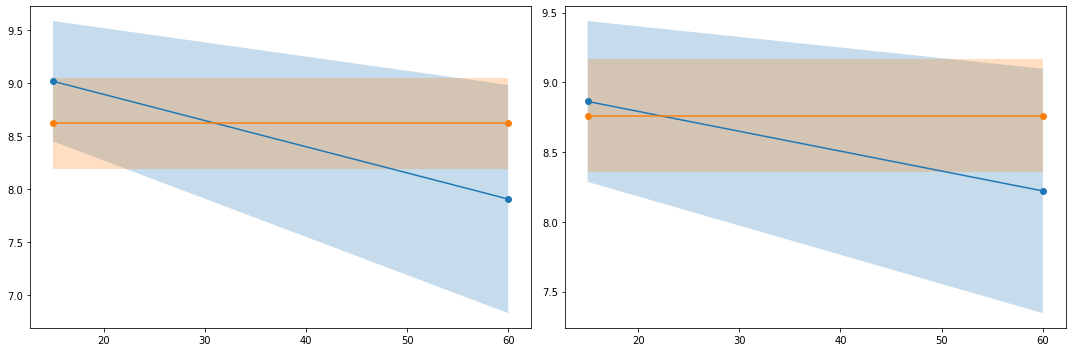

In [365]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = [[15, 1, 1],
     [60, 1, 1],
     [0, 0, 1],
     [0, 0, 1]
    ]

presults = mat_results_linear.get_prediction(p)

plt.plot([15, 60], mat_results_linear.predict(p)[:2], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([15, 60], mat_results_linear.predict(p)[2:], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[2:, 0], presults.conf_int()[2:, 1], alpha=0.25)

plt.subplot(1, 2, 2)

presults = pat_results_linear.get_prediction(p)

plt.plot([15, 60], pat_results_linear.predict(p)[:2], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([15, 60], pat_results_linear.predict(p)[2:], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[2:, 0], presults.conf_int()[2:, 1], alpha=0.25)

plt.tight_layout()
plt.show()


## block age model

In [366]:
age_intervals_mat = np.arange(20, 50, 5)
age_intervals_pat = np.arange(20, 50, 5)

X_mat = np.zeros((len(children), len(age_intervals_mat)+2))
X_mat[mom_age_at_birth != -1, np.digitize(mom_age_at_birth[mom_age_at_birth != -1], age_intervals_mat)] = 1
X_mat[mom_age_at_birth != -1, -2] = 1
X_mat[:, -1] = 1

mat_model = sm.GLM(mom_recomb, sibpair_to_child.dot(X_mat))
mat_results = mat_model.fit()
print(mat_results.summary())
print(mat_results.pvalues)

X_pat = np.zeros((len(children), len(age_intervals_pat)+2))
X_pat[dad_age_at_birth != -1, np.digitize(dad_age_at_birth[dad_age_at_birth != -1], age_intervals_pat)] = 1
X_pat[dad_age_at_birth != -1, -2] = 1
X_pat[:, -1] = 1

pat_model = sm.GLM(dad_recomb, sibpair_to_child.dot(X_pat))
pat_results = pat_model.fit()
print(pat_results.summary())
print(pat_results.pvalues)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1968
Model:                            GLM   Df Residuals:                     1960
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          50.423
Method:                          IRLS   Log-Likelihood:                -6646.2
Date:                Thu, 14 Oct 2021   Deviance:                       98829.
Time:                        18:15:18   Pearson chi2:                 9.88e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.0101      2.831     -0.710      0.4

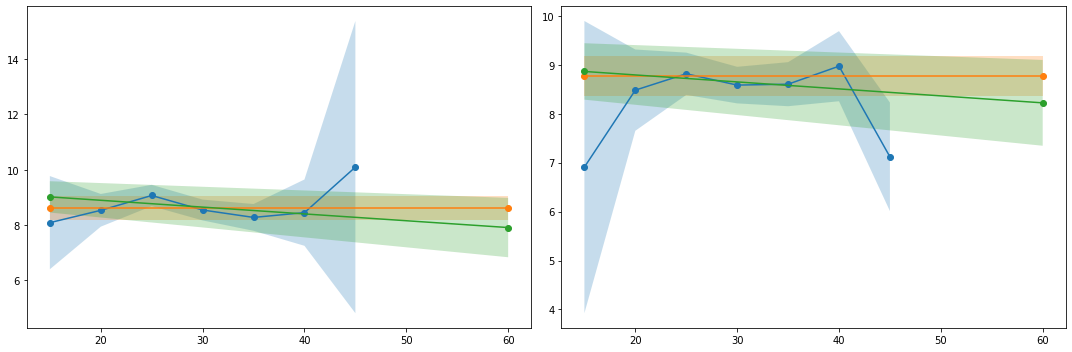

In [367]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = np.zeros((len(age_intervals_mat)+3, len(age_intervals_mat)+2))
p[:-2, :-1] = np.identity(len(age_intervals_mat)+1)
p[:-2, -2] = 1
p[:, -1] = 1

presults = mat_results.get_prediction(p)
pred = mat_results.predict(p)


plt.plot([age_intervals_mat[0]-5] + age_intervals_mat.tolist(), pred[:-2], marker='o')
plt.fill_between([age_intervals_mat[0]-5] + age_intervals_mat.tolist(),
                 presults.conf_int()[:-2, 0], presults.conf_int()[:-2, 1], alpha=0.25)

plt.plot([15, 60], pred[-2:], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[-2:, 0], presults.conf_int()[-2:, 1], alpha=0.25)

p = [[15, 1, 1],
     [60, 1, 1],
#     [0, 0, 1],
#     [0, 0, 1]
    ]

presults = mat_results_linear.get_prediction(p)

plt.plot([15, 60], mat_results_linear.predict(p)[:2], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.subplot(1, 2, 2)

p = np.zeros((len(age_intervals_pat)+3, len(age_intervals_pat)+2))
p[:-2, :-1] = np.identity(len(age_intervals_pat)+1)
p[:-2, -2] = 1
p[:, -1] = 1

presults = pat_results.get_prediction(p)
pred = pat_results.predict(p)


plt.plot([age_intervals_pat[0]-5] + age_intervals_pat.tolist(), pred[:-2], marker='o')
plt.fill_between([age_intervals_pat[0]-5] + age_intervals_pat.tolist(),
                 presults.conf_int()[:-2, 0], presults.conf_int()[:-2, 1], alpha=0.25)

plt.plot([15, 60], pred[-2:], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[-2:, 0], presults.conf_int()[-2:, 1], alpha=0.25)

p = [[15, 1, 1],
     [60, 1, 1],
#     [0, 0, 1],
#     [0, 0, 1]
    ]

presults = pat_results_linear.get_prediction(p)

plt.plot([15, 60], pat_results_linear.predict(p)[:2], marker='o')
plt.fill_between([15, 60],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.tight_layout()
plt.show()


## linear age model with phenotype

In [368]:
phenotype = np.array([int(sample_to_affected[child]=='2') for child in children])


In [369]:

X_mat = np.zeros((len(children), 6))
X_mat[mom_age_at_birth != -1, 0] = mom_age_at_birth[mom_age_at_birth != -1]
X_mat[mom_age_at_birth != -1, 1] = 1
X_mat[:, 2] = 1
X_mat[(mom_age_at_birth != -1) & (phenotype==1), 3] = mom_age_at_birth[(mom_age_at_birth != -1) & (phenotype==1)]
X_mat[(mom_age_at_birth != -1) & (phenotype==1), 4] = 1
X_mat[phenotype==1, 5] = 1

mat_model = sm.GLM(mom_recomb, sibpair_to_child.dot(X_mat))
mat_results = mat_model.fit()
print(mat_results.summary())
print(mat_results.pvalues)

X_pat = np.zeros((len(children), 6))
X_pat[dad_age_at_birth != -1, 0] = dad_age_at_birth[dad_age_at_birth != -1]
X_pat[dad_age_at_birth != -1, 1] = 1
X_pat[:, 2] = 1
X_pat[(dad_age_at_birth != -1) & (phenotype==1), 3] = mom_age_at_birth[(dad_age_at_birth != -1) & (phenotype==1)]
X_pat[(dad_age_at_birth != -1) & (phenotype==1), 4] = 1
X_pat[phenotype==1, 5] = 1

pat_model = sm.GLM(dad_recomb, sibpair_to_child.dot(X_pat))
pat_results = pat_model.fit()
print(pat_results.summary())
print(pat_results.pvalues)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1968
Model:                            GLM   Df Residuals:                     1962
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          50.108
Method:                          IRLS   Log-Likelihood:                -6641.0
Date:                Thu, 14 Oct 2021   Deviance:                       98312.
Time:                        18:15:29   Pearson chi2:                 9.83e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1188      0.044     -2.703      0.0

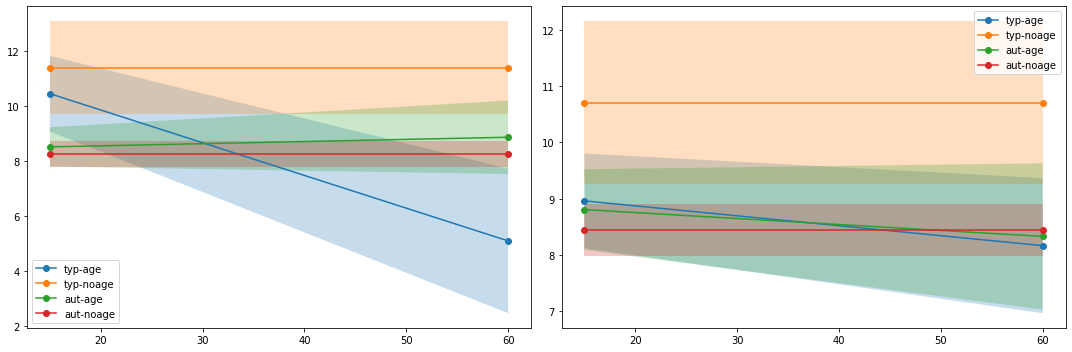

In [370]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = [[15, 1, 1, 0, 0, 0],
     [60, 1, 1, 0, 0, 0],
     [0, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0, 0],
     [15, 1, 1, 15, 1, 1],
     [60, 1, 1, 60, 1, 1],
     [0, 0, 1, 0, 0, 1],
     [0, 0, 1, 0, 0, 1]
    ]

presults = mat_results.get_prediction(p)
pred = mat_results.predict(p)

plt.plot([15, 60], pred[:2], marker='o', label='typ-age')
plt.fill_between([15, 60],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([15, 60], pred[2:4], marker='o', label='typ-noage')
plt.fill_between([15, 60],
                 presults.conf_int()[2:4, 0], presults.conf_int()[2:4, 1], alpha=0.25)

plt.plot([15, 60], pred[4:6], marker='o', label='aut-age')
plt.fill_between([15, 60],
                 presults.conf_int()[4:6, 0], presults.conf_int()[4:6, 1], alpha=0.25)

plt.plot([15, 60], pred[6:8], marker='o', label='aut-noage')
plt.fill_between([15, 60],
                 presults.conf_int()[6:8, 0], presults.conf_int()[6:8, 1], alpha=0.25)
plt.legend()

plt.subplot(1, 2, 2)

presults = pat_results.get_prediction(p)
pred = pat_results.predict(p)

plt.plot([15, 60], pred[:2], marker='o', label='typ-age')
plt.fill_between([15, 60],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([15, 60], pred[2:4], marker='o', label='typ-noage')
plt.fill_between([15, 60],
                 presults.conf_int()[2:4, 0], presults.conf_int()[2:4, 1], alpha=0.25)

plt.plot([15, 60], pred[4:6], marker='o', label='aut-age')
plt.fill_between([15, 60],
                 presults.conf_int()[4:6, 0], presults.conf_int()[4:6, 1], alpha=0.25)

plt.plot([15, 60], pred[6:8], marker='o', label='aut-noage')
plt.fill_between([15, 60],
                 presults.conf_int()[6:8, 0], presults.conf_int()[6:8, 1], alpha=0.25)
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
mom_age, mom_recomb, mom_ibd = np.zeros((len(sibpairs_to_include_mat),), dtype=int), np.zeros((len(sibpairs_to_include_mat),), dtype=int), np.zeros((len(sibpairs_to_include_mat),))
dad_age, dad_recomb, dad_ibd = np.zeros((len(sibpairs_to_include_pat),), dtype=int), np.zeros((len(sibpairs_to_include_pat),), dtype=int), np.zeros((len(sibpairs_to_include_pat),))

age_intervals_mat = np.arange(20, 45, 5)
age_intervals_pat = np.arange(20, 50, 5)

#age_intervals_mat = np.quantile(list(child_to_mom_age.values()), np.arange(0.33, 1, 0.33))
#age_intervals_pat = np.quantile(list(child_to_dad_age.values()), np.arange(0.33, 1, 0.33))

sibpair_to_child = np.zeros((len(sibpairs_tp)))

mom_age_X = np.zeros((len(sibpairs_to_include_mat), len(age_intervals_mat)+2), dtype=int)
dad_age_X = np.zeros((len(sibpairs_to_include_pat), len(age_intervals_pat)+2), dtype=int)

mom_age_phen = np.zeros((len(sibpairs_to_include_mat), 4), dtype=int)
dad_age_phen = np.zeros((len(sibpairs_to_include_pat), 4), dtype=int)

for i, (sib1, sib2) in enumerate(sibpairs_to_include_mat):
    mom_age[i] = child_to_mom_age_at_birth[sib1]+child_to_mom_age_at_birth[sib2]
    mom_recomb[i] = sibpair_to_num_crossovers_mat[(sib1, sib2)]
    mom_ibd[i] = 100*sibpair_to_ibd_mat[(sib1, sib2)]
    
    mom_age_X[i, np.digitize(child_to_mom_age_at_birth[sib1], age_intervals_mat)] = 1
    mom_age_X[i, np.digitize(child_to_mom_age_at_birth[sib2], age_intervals_mat)] = 1
    
    mom_age_phen[i, int(sample_to_affected[sib1]=='2')] = child_to_mom_age_at_birth[sib1]
    mom_age_phen[i, 2+int(sample_to_affected[sib1]=='2')] = 1
    mom_age_phen[i, int(sample_to_affected[sib2]=='2')] += child_to_mom_age_at_birth[sib2]
    mom_age_phen[i, 2+int(sample_to_affected[sib2]=='2')] += 1
    

for i, (sib1, sib2) in enumerate(sibpairs_to_include_pat):
    dad_age[i] = child_to_dad_age_at_birth[sib1]+child_to_dad_age_at_birth[sib2]
    dad_recomb[i] = sibpair_to_num_crossovers_pat[(sib1, sib2)]
    dad_ibd[i] = 100*sibpair_to_ibd_pat[(sib1, sib2)]
    
    dad_age_X[i, np.digitize(child_to_dad_age_at_birth[sib1], age_intervals_pat)] = 1
    dad_age_X[i, np.digitize(child_to_dad_age_at_birth[sib2], age_intervals_pat)] = 1
    
    dad_age_phen[i, int(sample_to_affected[sib1]=='2')] = child_to_dad_age_at_birth[sib1]
    dad_age_phen[i, 2+int(sample_to_affected[sib1]=='2')] = 1
    dad_age_phen[i, int(sample_to_affected[sib2]=='2')] += child_to_dad_age_at_birth[sib2]
    dad_age_phen[i, 2+int(sample_to_affected[sib2]=='2')] += 1
    

assert np.all(mom_age_X[:, -1]==0)
assert np.all(dad_age_X[:, -1]==0)


mom_age_X[:, -1] = 1
dad_age_X[:, -1] = 1


print(np.sum(mom_age_X, axis=0))
print(np.sum(mom_age_phen, axis=0))


[  51  337  757  783  459   93 1557]
[23360 70652   781  2333]


60.0
(0.13791964072237126, 0.00021855575665167697)
(0.0783022144743937, 0.02299119900291226)
64.0
(-0.0012763362526345967, 0.9724247810045157)
(-0.07002759471803878, 0.05102697791541289)


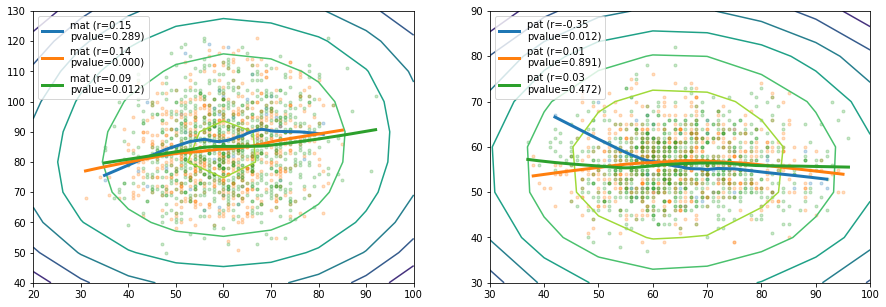

In [47]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(mom_age[phenotype_mat==0], mom_recomb[phenotype_mat==0], marker='.', alpha=0.25)
plt.scatter(mom_age[phenotype_mat==1], mom_recomb[phenotype_mat==1], marker='.', alpha=0.25)
plt.scatter(mom_age[phenotype_mat==2], mom_recomb[phenotype_mat==2], marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mom_age[:, np.newaxis],
                                                                    mom_recomb[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(mom_recomb[phenotype_mat==0], mom_age[phenotype_mat==0], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age[phenotype_mat==0], mom_recomb[phenotype_mat==0]))

l = sm.nonparametric.lowess(mom_recomb[phenotype_mat==1], mom_age[phenotype_mat==1], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age[phenotype_mat==1], mom_recomb[phenotype_mat==1]))

l = sm.nonparametric.lowess(mom_recomb[phenotype_mat==2], mom_age[phenotype_mat==2], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age[phenotype_mat==2], mom_recomb[phenotype_mat==2]))

plt.legend()

print(np.median(mom_age))
print(stats.pearsonr(mom_age[mom_age<np.median(mom_age)], mom_recomb[mom_age<np.median(mom_age)]))
print(stats.pearsonr(mom_age[mom_age>=np.median(mom_age)], mom_recomb[mom_age>=np.median(mom_age)]))

plt.subplot(1, 2, 2)

plt.scatter(dad_age[phenotype_pat==0], dad_recomb[phenotype_pat==0], marker='.', alpha=0.25)
plt.scatter(dad_age[phenotype_pat==1], dad_recomb[phenotype_pat==1], marker='.', alpha=0.25)
plt.scatter(dad_age[phenotype_pat==2], dad_recomb[phenotype_pat==2], marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((dad_age[:, np.newaxis],
                                                                    dad_recomb[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(dad_recomb[phenotype_pat==0], dad_age[phenotype_pat==0], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age[phenotype_pat==0], dad_recomb[phenotype_pat==0]))

l = sm.nonparametric.lowess(dad_recomb[phenotype_pat==1], dad_age[phenotype_pat==1], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age[phenotype_pat==1], dad_recomb[phenotype_pat==1]))

l = sm.nonparametric.lowess(dad_recomb[phenotype_pat==2], dad_age[phenotype_pat==2], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age[phenotype_pat==2], dad_recomb[phenotype_pat==2]))

plt.legend()

print(np.median(dad_age))
print(stats.pearsonr(dad_age[dad_age<np.median(dad_age)], dad_recomb[dad_age<np.median(dad_age)]))
print(stats.pearsonr(dad_age[dad_age>=np.median(dad_age)], dad_recomb[dad_age>=np.median(dad_age)]))


plt.show()

60.0
(0.13791964072237126, 0.00021855575665167697)
(0.0783022144743937, 0.02299119900291226)
64.0
(-0.0012763362526345967, 0.9724247810045157)
(-0.07002759471803878, 0.05102697791541289)


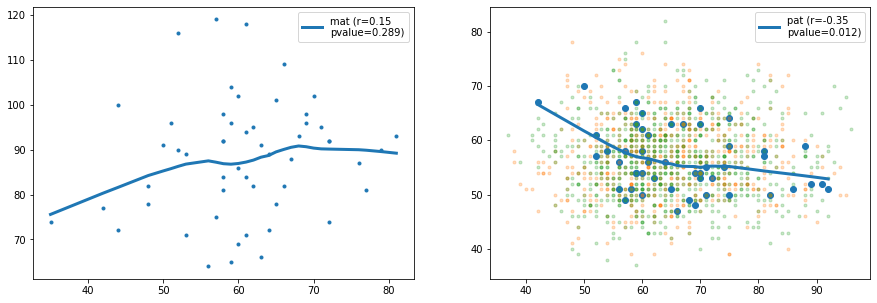

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(mom_age[phenotype_mat==0], mom_recomb[phenotype_mat==0], marker='.')
#plt.scatter(mom_age[phenotype_mat==1], mom_recomb[phenotype_mat==1], marker='.', alpha=0.25)
#plt.scatter(mom_age[phenotype_mat==2], mom_recomb[phenotype_mat==2], marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mom_age[:, np.newaxis],
                                                                    mom_recomb[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
#plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(mom_recomb[phenotype_mat==0], mom_age[phenotype_mat==0], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age[phenotype_mat==0], mom_recomb[phenotype_mat==0]))

#l = sm.nonparametric.lowess(mom_recomb[phenotype_mat==1], mom_age[phenotype_mat==1], return_sorted=True)
#plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age[phenotype_mat==1], mom_recomb[phenotype_mat==1]))
#
#l = sm.nonparametric.lowess(mom_recomb[phenotype_mat==2], mom_age[phenotype_mat==2], return_sorted=True)
#plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age[phenotype_mat==2], mom_recomb[phenotype_mat==2]))

plt.legend()

print(np.median(mom_age))
print(stats.pearsonr(mom_age[mom_age<np.median(mom_age)], mom_recomb[mom_age<np.median(mom_age)]))
print(stats.pearsonr(mom_age[mom_age>=np.median(mom_age)], mom_recomb[mom_age>=np.median(mom_age)]))

plt.subplot(1, 2, 2)

plt.scatter(dad_age[phenotype_pat==0], dad_recomb[phenotype_pat==0], marker='o')
plt.scatter(dad_age[phenotype_pat==1], dad_recomb[phenotype_pat==1], marker='.', alpha=0.25)
plt.scatter(dad_age[phenotype_pat==2], dad_recomb[phenotype_pat==2], marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((dad_age[:, np.newaxis],
                                                                    dad_recomb[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
#plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(dad_recomb[phenotype_pat==0], dad_age[phenotype_pat==0], return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age[phenotype_pat==0], dad_recomb[phenotype_pat==0]))

#l = sm.nonparametric.lowess(dad_recomb[phenotype_pat==1], dad_age[phenotype_pat==1], return_sorted=True)
#plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age[phenotype_pat==1], dad_recomb[phenotype_pat==1]))

#l = sm.nonparametric.lowess(dad_recomb[phenotype_pat==2], dad_age[phenotype_pat==2], return_sorted=True)
#plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age[phenotype_pat==2], dad_recomb[phenotype_pat==2]))

plt.legend()

print(np.median(dad_age))
print(stats.pearsonr(dad_age[dad_age<np.median(dad_age)], dad_recomb[dad_age<np.median(dad_age)]))
print(stats.pearsonr(dad_age[dad_age>=np.median(dad_age)], dad_recomb[dad_age>=np.median(dad_age)]))


plt.show()

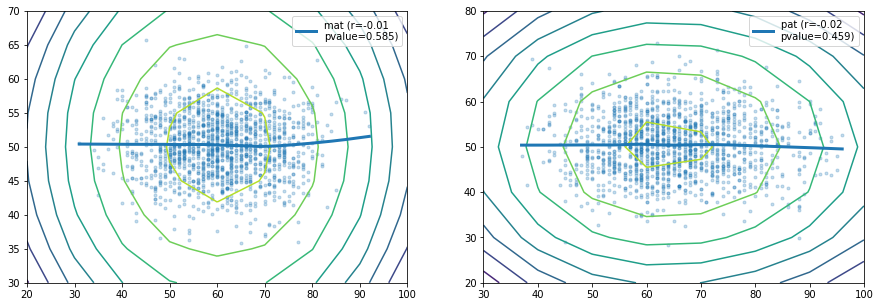

In [49]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(mom_age, mom_ibd, marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mom_age[:, np.newaxis],
                                                                    mom_ibd[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(mom_ibd, mom_age, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age, mom_ibd),
                )
plt.legend()

plt.subplot(1, 2, 2)

plt.scatter(dad_age, dad_ibd, marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((dad_age[:, np.newaxis],
                                                                    dad_ibd[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(dad_ibd, dad_age, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age, dad_ibd),
                )
plt.legend()
plt.show()

In [50]:
mat_model = sm.GLM(mom_recomb, mom_age_X)
mat_results = mat_model.fit()
print(mat_results.summary())

pat_model = sm.GLM(dad_recomb, dad_age_X)
pat_results = pat_model.fit()
print(pat_results.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1557
Model:                            GLM   Df Residuals:                     1550
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          165.33
Method:                          IRLS   Log-Likelihood:                -6182.3
Date:                Thu, 14 Oct 2021   Deviance:                   2.5626e+05
Time:                        15:02:28   Pearson chi2:                 2.56e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.5282      1.945     -1.814      0.0

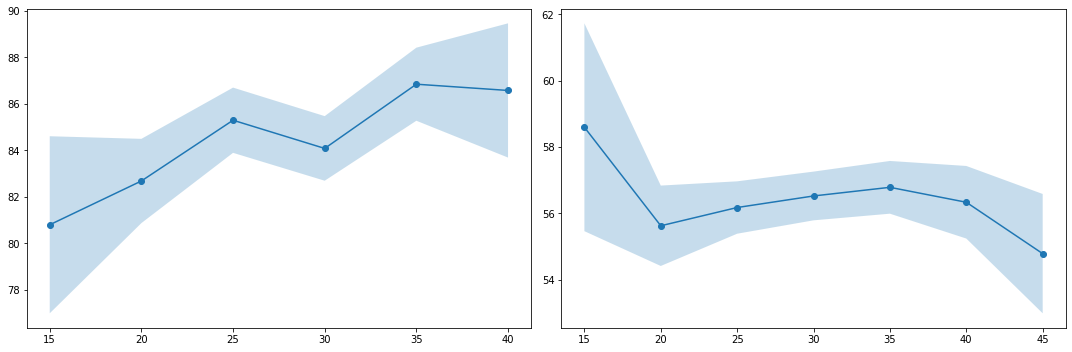

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = np.zeros((len(age_intervals_mat)+1, len(age_intervals_mat)+2))
p[:, :-1] = np.identity(len(age_intervals_mat)+1)
print()
p[:, -1] = 1

presults = mat_results.get_prediction(p)

plt.plot([age_intervals_mat[0]-5] + age_intervals_mat.tolist(), mat_results.predict(p), marker='o')
plt.fill_between([age_intervals_mat[0]-5] + age_intervals_mat.tolist(),
                 presults.conf_int()[:, 0], presults.conf_int()[:, 1], alpha=0.25)

plt.subplot(1, 2, 2)

p = np.zeros((len(age_intervals_pat)+1, len(age_intervals_pat)+2))
p[:, :-1] = np.identity(len(age_intervals_pat)+1)
print()
p[:, -1] = 1

presults = pat_results.get_prediction(p)

plt.plot([age_intervals_pat[0]-5] + age_intervals_pat.tolist(), pat_results.predict(p), marker='o')
plt.fill_between([age_intervals_pat[0]-5] + age_intervals_pat.tolist(),
                 presults.conf_int()[:, 0], presults.conf_int()[:, 1], alpha=0.25)

plt.tight_layout()
plt.show()


In [52]:
mat_model = sm.GLM(mom_recomb, mom_age_phen)
mat_results = mat_model.fit()
print(mat_results.summary())

pat_model = sm.GLM(dad_recomb, dad_age_phen)
pat_results = pat_model.fit()
print(pat_results.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1557
Model:                            GLM   Df Residuals:                     1553
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          165.99
Method:                          IRLS   Log-Likelihood:                -6186.9
Date:                Thu, 14 Oct 2021   Deviance:                   2.5779e+05
Time:                        15:02:28   Pearson chi2:                 2.58e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2067      0.086      2.406      0.0

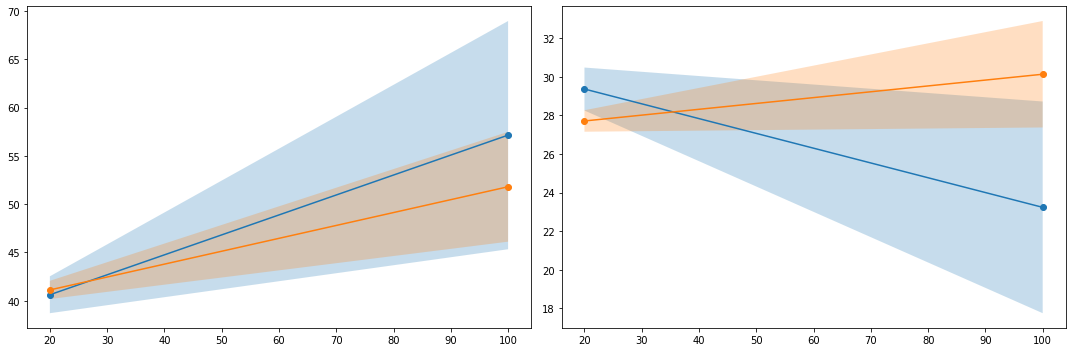

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = [[20, 0, 1, 0],
     [100, 0, 1, 0],
     [0, 20, 0, 1],
     [0, 100, 0, 1]]

presults = mat_results.get_prediction(p)

plt.plot([20, 100], mat_results.predict(p)[:2], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([20, 100], mat_results.predict(p)[2:], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[2:, 0], presults.conf_int()[2:, 1], alpha=0.25)

plt.subplot(1, 2, 2)

presults = pat_results.get_prediction(p)

plt.plot([20, 100], pat_results.predict(p)[:2], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([20, 100], pat_results.predict(p)[2:], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[2:, 0], presults.conf_int()[2:, 1], alpha=0.25)

plt.tight_layout()
plt.show()
